In [1]:
#https://github.com/Lakshmi-1212/FundamentalAnalyzer/blob/main/FundamentalAnalyzer.ipynb
import pandas as pd


from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

from time import sleep

import re

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") 

In [2]:
SCRIPS = ['BAJFINANCE','DMART'] #,'AXISBANK','KOTAKBANK','SBIN','CANBK']
# IT_SCRIPS = ['INFY', 'HCLTECH', 'LTI', 'TCS','LTTS', 'WIPRO' ]
# SCRIPS = IT_SCRIPS

# WEB SCRAPING

In [3]:
def extract_table_by_class(soup, section_id, class_name):
    section_html = soup.find('section',{'id': section_id})
    table_html = section_html.find('table',{'class': class_name})

    headers = []
    for header in table_html.find_all('th'):
        headers.append(  header.text or 'Type')

    table_df = pd.DataFrame(columns = headers)

    for row_element in table_html.find_all('tr')[1:]:
            row_data = row_element.find_all('td')
            row = [tr.text.strip() for tr in row_data]
            length = len(table_df)
            table_df.loc[length] = row 
            
    return table_df
    

def fetch_number_span(list_element):
    num_span = list_element.find('span',{'class':'number'})

    num_span = num_span.text.replace(',', '')
    return float(num_span) if (num_span != '') else 0.0
    
def extract_scrip_ratios(soup,div_class, ul_id):
    div_html = soup.find('div',{'class': div_class})
    ul_html = div_html.find('ul',{'id': ul_id})
    current_price = 0
    high = 0.0
    low = 0.0
    dividend_yield = 0.0
    pe = 0.0
    roe = 0.0
    roce = 0.0
    market_cap = 0.0
     
    scrip_data = pd.Series()
    
    for li in ul_html.find_all("li"):
        name_span = li.find('span',{'class':'name'})
        
        if 'Current Price' in name_span.text: 
            current_price = fetch_number_span(li)

        if 'High / Low' in name_span.text:
            num_spans = li.find_all('span',{'class':'number'})
            if(len(num_spans) == 2):
                high_num = num_spans[0].text.replace(',', '')
                low_num = num_spans[1].text.replace(',', '')
                high = float(high_num) if (high_num != '') else 0.0
                low = float(low_num) if (low_num != '') else 0.0 
                
        if 'Market Cap' in name_span.text: 
            market_cap = fetch_number_span(li)
            
        if 'Stock P/E' in name_span.text:
            pe = fetch_number_span(li) 
            
        if 'Dividend Yield' in name_span.text:
            dividend_yield = fetch_number_span(li) 
            
        if 'ROCE' in name_span.text:
            roce = fetch_number_span(li) 
            
        if 'ROE' in name_span.text:
            roe = fetch_number_span(li) 
            
    scrip_data['Price'] = current_price
    scrip_data['High'] = high
    scrip_data['Low'] = low
    scrip_data['Market_Cap'] = market_cap
    scrip_data['PE'] = pe
    scrip_data['Dividend'] = dividend_yield
    scrip_data['ROCE'] = roce
    scrip_data['ROE'] = roe
    return scrip_data


BASE_URL = 'https://www.screener.in/company/'
def fetch_scrip_data(scrip, consolidated=True):
    link = f'{BASE_URL}{scrip}'
    link += '/consolidated' if consolidated else ''
    
    hdr = {'User-Agent':'Mozilla/5.0'}
    req = Request(link,headers=hdr)
    
    profit_loss_df = None
    scrip_data = pd.Series()
    try:
        page=urlopen(req)
        soup = BeautifulSoup(page)
        scrip_data = extract_scrip_ratios(soup,'company-ratios', 'top-ratios')
        profit_loss_df = extract_table_by_class(soup, 'profit-loss', 'data-table responsive-text-nowrap')
    except:
        print(f'EXCEPTION THROWN: UNABLE TO FETCH DATA')

    return scrip_data, profit_loss_df
 

     

def extract_last_n_years_pl(pl_df, n_years):
    # Extract data for all years from the column names
    mon_year_regex = re.compile('([A-Z][a-z]{2}) (\d{4})')
    years = {}
    for col in list(pl_df.columns):
        res = re.search(mon_year_regex,col)
        if res:
            years[res.group(2)] = col

    # Get only the last n (PROFIT_LOSS_YEARS) years for checking the P&L 
    years_list = sorted(years.keys())
    years_list = years_list[-n_years:]
    cols = [years[year] for year in years_list]
    print(pl_df[cols])
    
    pl_values = pl_df[cols].iloc[0, :].values.tolist()
    pl_values = [float(x.replace(',', '')) for x in pl_values] 
    return pl_values
 

# CHECK IF CURRENT PRICE IS BELOW PREVIOUS HIGH 

In [4]:
# Check if current price is below the 52-week high with a certain threshold
# Eg: If current price is 100, 52-week high is 120, threshold is 10%, then return True
#     If current price is 100, 52-week high is 105, threshold is 10%, then return False
def check_current_below_high_threshold(current,high, threshold_percent):
    below_threshold = False
    if ((current < high) & ((high-current)/high*100 > threshold_percent)):
        below_threshold = True
    return below_threshold   

# PROFIT/LOSS BASED STRATEGY

STRATEGY:  
BUY recommendation if:  
    1. Net profit for the company has been increasing consistently in the last few (config) years  
    2. Current market price is atleast 10% below the 52-week high (stock is not trading around all time high)

In [5]:
# PROFIT-LOSS STRATEGY - CONFIG
PROFIT_LOSS_YEARS = 3
SCREENER_ROW_PL = 'Net Profit' # or can be 'Profit before tax'
CURRENT_HIGH_THRESHOLD_PERCENT = 10

In [10]:
def apply_pl_strategy(current_price, scrip_high, profit_loss_df, high_threshold_percent):
    
#     STRATEGY:
#     BUY recommendation if:
#         1. Profit/Loss for the company has been increasing consistently in the last few years.
#         2. Current market price is below 10% of 52-week high

    # SET DEFAULT TO STOCK AS NO-ACTION
    strategy_result = 'WAIT'
    try: 

        # CHECK IF REQUIRED VALUES COULD BE SCRAPED
        if (current_price is None or current_price == 0.0 or 
            scrip_high is None or scrip_high == 0.0):
            strategy_result = 'NOT FOUND'

        else:
            profit_loss_df = profit_loss_df[profit_loss_df['Type'] == SCREENER_ROW_PL]
            last_pl_list = extract_last_n_years_pl(profit_loss_df, PROFIT_LOSS_YEARS)
            print(f'Profit/Loss for last {PROFIT_LOSS_YEARS} years:{last_pl_list}')
            print(f'Current Price:{current_price}, 52-week High:{scrip_high}, Threshold%: {high_threshold_percent}%')

            # CHECK IF PROFIT-LOSS IS CONSISTENTLY INCREASING
            if(last_pl_list == sorted(last_pl_list)):
                # IF YES, CHECK IF CURRENT MARKET VALUE IS NOT AT ALL TIME HIGH
                if check_current_below_high_threshold(current_price, scrip_high, high_threshold_percent):
                    # BUY RECOMMENDATION
                    strategy_result = 'BUY'
    except Exception as e:
        print(f"UNABLE TO APPLY PROFIT-LOSS STRATEGY ON {scrip}. Exception: {e}")

    return strategy_result


# SCRAPE THE DATA

In [11]:
final_df = pd.DataFrame({'Symbol':SCRIPS},
                        columns=['Symbol','Market_Cap','Price','High','Low','PE','ROE','ROCE','Dividend','STRATEGY_PL']).set_index('Symbol')


final_df
# LOOP THROUGH EACH SCRIP
for scrip in SCRIPS:
    print(f"\nSYMBOL: {scrip}")
    scrip_data, profit_loss_df = fetch_scrip_data(scrip)
    
    print(scrip_data)
    
    for index, value in scrip_data.items():
        final_df[index][scrip] = value
    
    strategy_result = apply_pl_strategy(scrip_data['Price'], scrip_data['High'], profit_loss_df, CURRENT_HIGH_THRESHOLD_PERCENT)
    print(f"APPLYING PROFIT/LOSS STRATEGY ON {scrip}: {strategy_result}")
    final_df['STRATEGY_PL'][scrip] = strategy_result
    #sleep(2) # Add sleep if TOO MANY REQUESTS error (Error Code: 429) is thrown

display(final_df)
# dir(scrip_data)



SYMBOL: BAJFINANCE
Price           7233.00
High            8192.00
Low             5486.00
Market_Cap    446963.00
PE                34.10
Dividend           0.41
ROCE              11.80
ROE               23.50
dtype: float64
Empty DataFrame
Columns: [Mar 2021, Mar 2022, Mar 2023]
Index: []
UNABLE TO APPLY PROFIT-LOSS STRATEGY ON BAJFINANCE. Exception: single positional indexer is out-of-bounds
APPLYING PROFIT/LOSS STRATEGY ON BAJFINANCE: WAIT

SYMBOL: DMART
Price           4027.0
High            4208.0
Low             3292.0
Market_Cap    262174.0
PE               112.0
Dividend           0.0
ROCE              20.1
ROE               16.0
dtype: float64
Empty DataFrame
Columns: [Mar 2021, Mar 2022, Mar 2023]
Index: []
UNABLE TO APPLY PROFIT-LOSS STRATEGY ON DMART. Exception: single positional indexer is out-of-bounds
APPLYING PROFIT/LOSS STRATEGY ON DMART: WAIT


,Market_Cap,Price,High,Low,PE,ROE,ROCE,Dividend,STRATEGY_PL
Symbol,,,,,,,,,
BAJFINANCE,446963.0,7233.0,8192.0,5486.0,34.1,23.5,11.8,0.41,WAIT
DMART,262174.0,4027.0,4208.0,3292.0,112.0,16.0,20.1,0.0,WAIT


In [17]:
scrip

'DMART'

In [19]:
BASE_URL = 'https://www.screener.in/company/'


link = f'{BASE_URL}{scrip}'
link += '/consolidated' if True else ''
link

hdr = {'User-Agent':'Mozilla/5.0'}
req = Request(link,headers=hdr)

profit_loss_df = None
scrip_data = pd.Series()
try:
    page=urlopen(req)
    soup = BeautifulSoup(page)
    scrip_data = extract_scrip_ratios(soup,'company-ratios', 'top-ratios')
    profit_loss_df = extract_table_by_class(soup, 'profit-loss', 'data-table responsive-text-nowrap')
except e:
    print(e)

profit_loss_df
# scrip_data

,Type,Mar 2012,Mar 2013,Mar 2014,Mar 2015,Mar 2016,Mar 2017,Mar 2018,Mar 2019,Mar 2020,Mar 2021,Mar 2022,Mar 2023,TTM
0,Sales +,"2,209","3,341","4,686","6,439","8,584","11,898","15,033","20,005","24,870","24,143","30,976","42,840","46,653"
1,Expenses +,"2,071","3,126","4,345","5,983","7,919","10,929","13,680","18,371","22,742","22,398","28,474","39,201","42,876"
2,Operating Profit,138,215,341,456,664,969,"1,353","1,633","2,128","1,745","2,502","3,639","3,777"
3,OPM %,6%,6%,7%,7%,8%,8%,9%,8%,9%,7%,8%,8%,8%
4,Other Income +,14,15,16,20,17,28,88,48,60,194,114,128,140
5,Interest,26,43,56,72,91,122,60,47,69,42,54,67,63
6,Depreciation,37,46,57,82,98,128,159,212,374,414,498,639,669
7,Profit before tax,89,141,245,323,492,747,"1,222","1,422","1,745","1,483","2,064","3,060","3,186"
8,Tax %,32%,34%,34%,34%,35%,36%,34%,37%,25%,26%,28%,22%,
9,Net Profit +,60,94,161,212,320,479,806,902,"1,301","1,099","1,492","2,378","2,332"


# MARKET CAPITALIZATION PLOT

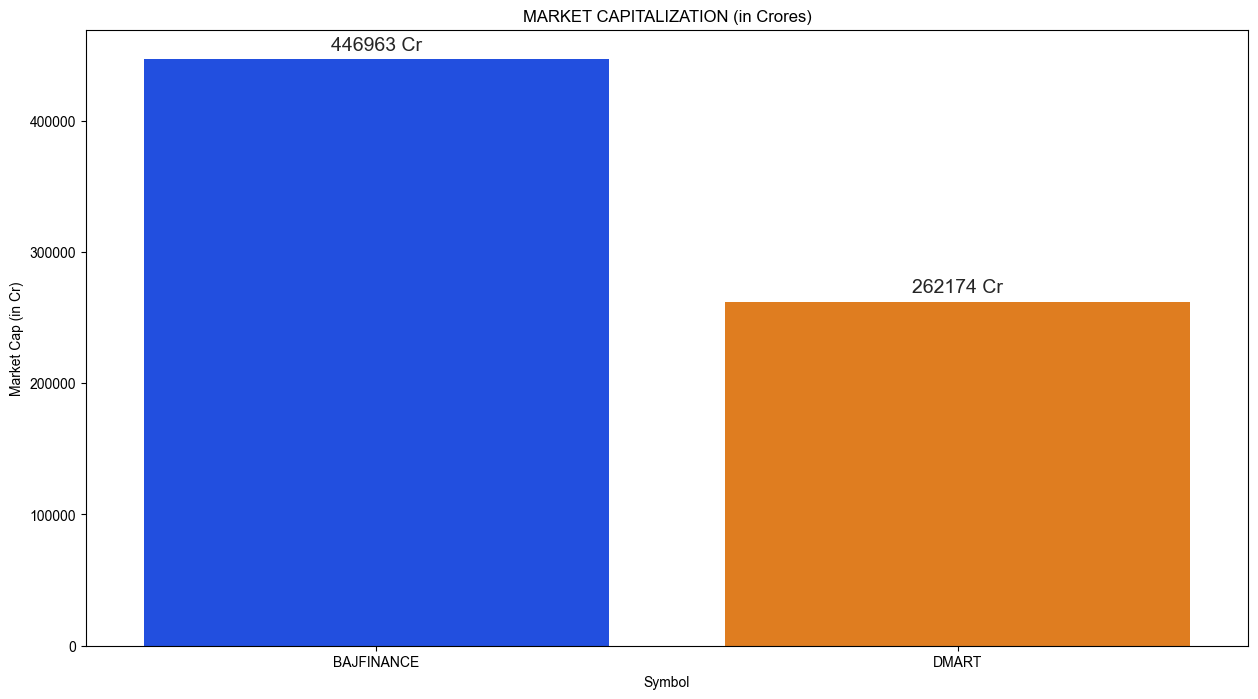

In [13]:
plt.figure(figsize = (15,8))

mark_cap_sorted_df = final_df.sort_values(by='Market_Cap', ascending = False)
ax = sns.barplot(x=mark_cap_sorted_df.index, y=mark_cap_sorted_df['Market_Cap'], palette = 'bright')
ax.set(xlabel="Symbol", ylabel='Market Cap (in Cr)',title = f'MARKET CAPITALIZATION (in Crores)') 
sns.set(font_scale = 1.5)

#annotate axis = seaborn axis
for p in ax.patches:
     ax.annotate("%.0f Cr" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=14,  xytext=(0, 10),
         textcoords='offset points')

# PLOT THE RESULT OF APPLYING THE PROFIT-LOSS STRATEGY

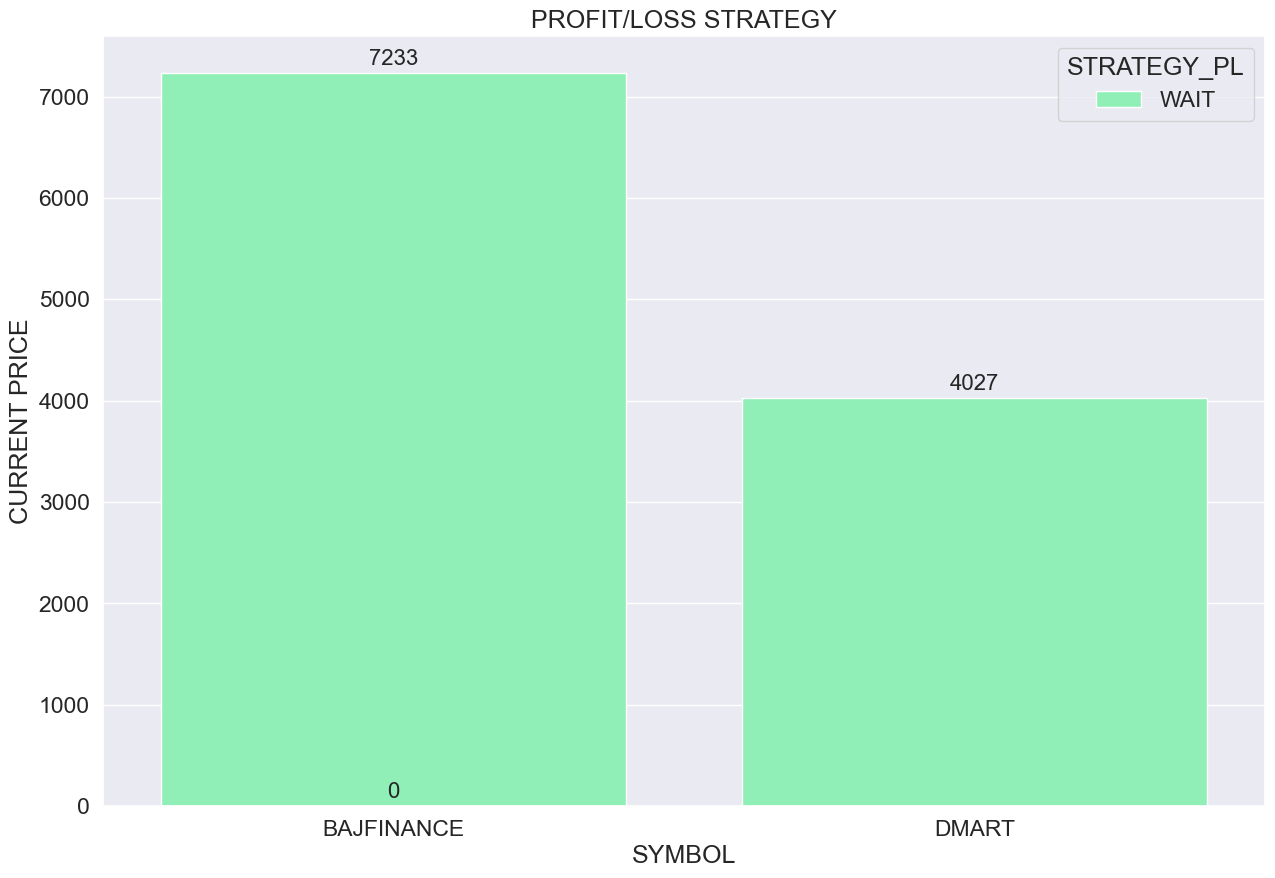

In [14]:
fig = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=final_df.index,y=final_df['Price'],hue=final_df['STRATEGY_PL'],palette='rainbow', dodge=False) 
ax.set(xlabel='SYMBOL', ylabel='CURRENT PRICE', title = 'PROFIT/LOSS STRATEGY')
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16,  xytext=(0, 10),
                 textcoords='offset points')

sns.set(font_scale = 1.5)
plt.show()


# PE - ROE - ROCE COMPARISON PLOT

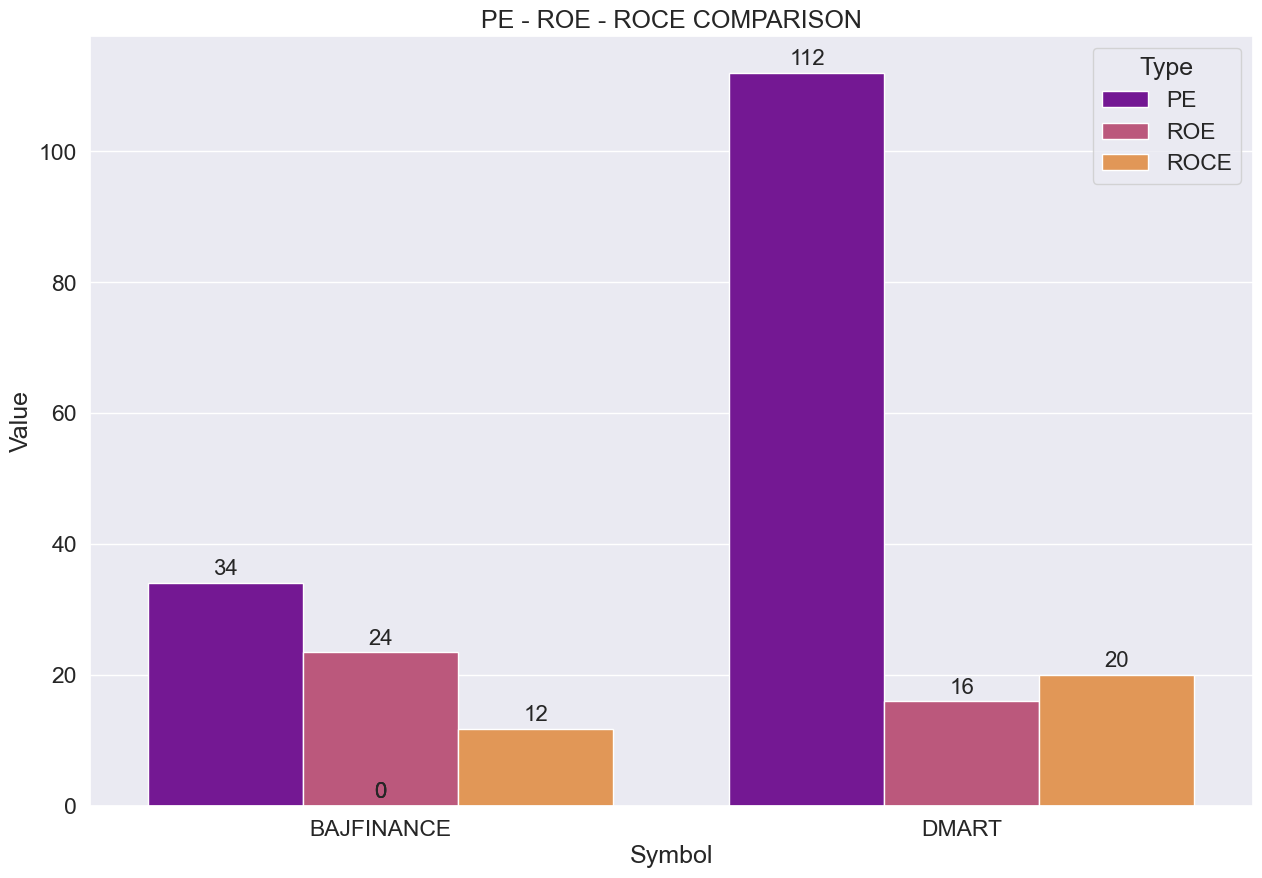

In [15]:
roe_data = pd.DataFrame(final_df['ROE']).rename(columns = {'ROE':'Value'})
roe_data['Type'] = 'ROE'

roce_data = pd.DataFrame(final_df['ROCE']).rename(columns = {'ROCE':'Value'})
roce_data['Type'] = 'ROCE'

pe_data = pd.DataFrame(final_df['PE']).rename(columns = {'PE':'Value'})
pe_data['Type'] = 'PE'

analysis_df = pd.concat([pe_data, roe_data,roce_data])
analysis_df

fig = plt.subplots(figsize=(15,10))

ax = sns.barplot(x=analysis_df.index,
           y=analysis_df['Value'],
           hue=analysis_df['Type'],
           palette = 'plasma')
ax.set( title = 'PE - ROE - ROCE COMPARISON')

for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16,  xytext=(0, 10),
                 textcoords='offset points')
        
plt.show()

# SAMPLE: EXTRACT THE MARKET CAP OF INFOSYS

In [16]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

SCRIP = 'INFY'
link = f'https://www.screener.in/company/{SCRIP}'
hdr = {'User-Agent':'Mozilla/5.0'}
req = Request(link,headers=hdr)
 
try:
    page=urlopen(req)
    soup = BeautifulSoup(page)
    
    div_html = soup.find('div',{'class': 'company-ratios'})
    ul_html = div_html.find('ul',{'id': 'top-ratios'})
    market_cap = 0.0
        
    for li in ul_html.find_all("li"):
        name_span = li.find('span',{'class':'name'})
        if 'Market Cap' in name_span.text: 
            num_span = li.find('span',{'class':'number'})
            num_span = num_span.text.replace(',', '')
            market_cap = float(num_span) if (num_span != '') else 0.0
    
    print(f'MARKET CAPITILIZATION - {SCRIP}: {market_cap} Cr')

except:
    print(f'EXCEPTION THROWN: UNABLE TO FETCH DATA FOR {SCRIP}')


MARKET CAPITILIZATION - INFY: 650185.0 Cr
